# Model Evaluation including GradCAM Visualizations

### Step 1: Import data
Consistent for all models. Only change output size!

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, CyclicLR
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,  roc_auc_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# set the size of the image according to your model needs
imageSize = 224 # ResNet works with 224x224 pixels

# Custom Dataset
class BiomarkerDataset(Dataset):
    def __init__(self, label_file, transform=None, num_frames=0):
        """
        Args:
            label_file (str): Path to the CSV file.
            transform (callable, optional): Transform to be applied on a sample.
            num_frames (int): Number of adjacent frames to use in the input sequence (1 adjacent frame -> 3 consecutive images).
        """
        self.data = pd.read_csv(label_file)
        self.transform = transform
        self.num_frames = num_frames
        
        # Normalization
        self.bcva_mean = self.data.iloc[:, 19].mean()
        self.bcva_std = self.data.iloc[:, 19].std()
        self.cst_mean = self.data.iloc[:, 20].mean()
        self.cst_std = self.data.iloc[:, 20].std()

        
        # Exclude indices which don't have enough adjacent images
        self.valid_indices = self.data[(self.data.iloc[:, 1] > num_frames) & (self.data.iloc[:, 1] < (50-num_frames))].index.tolist()

    def __len__(self):
        # we can't use the length of the data since we have to exclude the first and last image (for num_frames=1) of each OCT scan
        return len(self.valid_indices)

    def __getitem__(self, idx):
        
        # Base path
        img_base_path = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES'
        
        # Get the actual data index
        index = self.valid_indices[idx]
        
        # Initialize
        images = []
        
        # Load a sequence of consecutive images
        for i in range(index - self.num_frames, index + self.num_frames +1):
            img_path = img_base_path + self.data.iloc[i, 0]
            img = Image.open(img_path).convert("L") # 'L' is for grayscale; can be removed!?
            
            if self.transform is not None:
                # apply data transformations (transforms it to tensor)
                img = self.transform(img)
            
            # stack torch tensor
            img = img.squeeze(0)  # Removes the first dimension if it's 1
            images.append(img)
        
        # Stack the 3 grayscale images along the channel dimension
        # Resulting tensor shape will be [3, H, W]
        images = torch.stack(images, dim=0)
        # print(images.shape) # debugging
        
        # Biomarker columns
        labels = torch.tensor(self.data.iloc[index, 2:18].astype(float), dtype=torch.float32)
        
        # Get clinical data:
        eye_id = self.data.iloc[index, 18]
        bcva = self.data.iloc[index, 19]
        cst = self.data.iloc[index, 20]
        patient_id = self.data.iloc[index, 21]
        
        # Normalize
        bcva = (bcva - self.bcva_mean) / self.bcva_std
        cst = (cst - self.cst_mean) / self.cst_std

        # Convert clinical data to tensor
        clinical_data = torch.tensor([eye_id, bcva, cst, patient_id], dtype=torch.float32)
        
        return images, labels, clinical_data
    
    
# Define transformers

# Values for normalization taken from example paper
mean = 0.1706
std = 0.2112

# test without data augmentation
test_transformer = transforms.Compose([   
    transforms.Resize(imageSize), # Resize to models needs
    transforms.CenterCrop(imageSize), # shouldn't do anything
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# set up test loader (this one actually is being used)
test_dataset = BiomarkerDataset(label_file='OLIVES_Dataset_Labels/BiomarkerLabel_train_data.csv', transform=test_transformer, num_frames=1)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=16, pin_memory=True)


### Step 2: Load model
Both Fusion and none fusion Model

In [2]:
# input the used weights
weightsPath_FusionModel = "TrainedModels/FusionModelV2_ResNet50/FusionModelV2_ResNet50_f1weighted0.9940_k5_e40_p8_weights.pth"
weightsPath_ImageModel = "TrainedModels/ResNet50/ResNet50_f1weighted0.9504_k5_e35_p7_weights.pth"


In [3]:
# get to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## ---- Fusion model ----
class FusionModel(nn.Module):
    def __init__(self, num_eyeID, num_patientID):
        super(FusionModel, self).__init__()
        
        # Image feature extractor
        self.image_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.image_model.BackboneOutput = self.image_model.fc.in_features # should be 2048
        self.image_model.fc = nn.Identity() # remove final layer
        
        # Embedding layers for categorical data
        # These are only categorial data. Therefore just using the numerical value doesn't fit
        # The only difference a high patient ID f.e. should make, is that it's a new patient. Shouldn't lead to higher percentages of a biomaker
        # Alternativ: One-Hot Encoding
        self.patient_id_embedding = nn.Embedding(num_patientID, 16)
        self.eye_id_embedding = nn.Embedding(num_eyeID, 16)
        
        # Fully connected layers for numerical clinical data (e.g., BCVA, CST)
        self.clinical_fc = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        # Combine and compress all clinical data
        self.clinical_fusion_fc = nn.Sequential(
            nn.Linear(16 + 16 + 32, 32),  # Combine all clinical data
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 64)
        )
        
        # Final fusion layers
        self.fusion_fc = nn.Sequential(nn.Linear(self.image_model.BackboneOutput + 64, 16))
        # the sequential is leftover from testing and needed to load the old weights
        
    def forward(self, image, clinical_data):
        # Extract features from the image using ResNet50
        image_features = self.image_model(image)
        
        # Clinical Data
        # Split clinical data into components
        eye_id = clinical_data[:, 0].long()
        bcva = clinical_data[:, 1].view(-1, 1).float()
        cst = clinical_data[:, 2].view(-1, 1).float()
        patient_id = clinical_data[:, 3].long()
        # Embed categorical clinical data
        eye_id_features = self.eye_id_embedding(eye_id).squeeze(1)
        patient_id_features = self.patient_id_embedding(patient_id).squeeze(1)
        # Process numerical clinical data
        numerical_features = torch.cat([bcva, cst], dim=1)
        clinical_features = self.clinical_fc(numerical_features)
        # Combine all clinical features
        combined_clinical_features = torch.cat([patient_id_features, eye_id_features, clinical_features], dim=1)
        fused_clinical_features = self.clinical_fusion_fc(combined_clinical_features)
        
        # Combine all features
        fused_features = torch.cat([image_features, fused_clinical_features], dim=1)
   
        # Final prediction through fusion layers
        output = self.fusion_fc(fused_features)
        
        return output

# Make sure there are enough different IDs available
num_eyeID = 100
num_patientID = 300
# Create the model
FusionModel = FusionModel(num_eyeID,num_patientID).to(device)
FusionModel.name = "FusionModelV2_ResNet50"
FusionModel = FusionModel.to(device) # shift to GPU
FusionModel.load_state_dict(torch.load(weightsPath_FusionModel, weights_only=True)) # Load weights


## ---- ResNet50 ----
# Import pretrained model (choose one of them based on performance)
ImageModel = models.resnet50(weights=models.ResNet50_Weights.DEFAULT) # this is like pre-trained true
ImageModel.name = "ResNet50"
ImageModel.fc = nn.Linear(ImageModel.fc.in_features, 16) # Adapt it to the given task (update final layer)
ImageModel = ImageModel.to(device) # shift to GPU
ImageModel.load_state_dict(torch.load(weightsPath_ImageModel, weights_only=True)) # Load weights


<All keys matched successfully>

### Step 3: Evaluate model


In [4]:
# Evaluation Function
def evaluate_model(model, loader):
    """
    Evaluate the model and calculate metrics at the scan level.
    """
    model.eval()
    y_true, y_pred, eye_ids = [], [], []
    with torch.no_grad():
        for images, labels, clinical_data in loader:
            images, labels, clinical_data = (
                images.to(device),
                labels.to(device),
                clinical_data.to(device),
            )
            if isinstance(model, (models.ResNet)):
                outputs = model(images)
            else:
                outputs = model(images, clinical_data)            
            y_true.append(labels.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
            if clinical_data.size(1) > 0:  # Ensure Eye_ID exists
                eye_ids.append(clinical_data[:, 0].cpu().numpy())
            else:
                eye_ids.append([])  # No Eye_ID if no clinical data
    return np.vstack(y_true), np.vstack(y_pred), np.concatenate(eye_ids)

# Update the evaluation function to include combined confusion matrix
# Evaluate and Aggregate Results
def evaluate_with_eye_aggregation(model, loader):
    """
    Evaluate model performance with and without eye-level aggregation.
    """
    print("Evaluating Scan-Level Metrics...")
    y_true, y_pred, eye_ids = evaluate_model(model, loader)

    # Compute combined confusion matrix for scan-level predictions
    print("Plotting Combined Confusion Matrix for Scan-Level Predictions...")
    plot_combined_confusion_matrix(y_true, y_pred, "Scan-Level Combined Confusion Matrix")

    # Scan-Level Metrics
    scan_metrics = compute_metrics(y_true, y_pred)
    print(scan_metrics)

    # Eye-Level Metrics
    eye_metrics = None
    if len(eye_ids) > 0:
        print("Evaluating Eye-Level Metrics...")
        eye_true, eye_pred = aggregate_by_eye(y_true, y_pred, eye_ids)

        # Compute combined confusion matrix for eye-level predictions
        print("Plotting Combined Confusion Matrix for Eye-Level Predictions...")
        plot_combined_confusion_matrix(eye_true, eye_pred, "Eye-Level Combined Confusion Matrix")

        eye_metrics = compute_metrics(eye_true, eye_pred)
        print(eye_metrics)

    return scan_metrics, eye_metrics

def compute_metrics(y_true, y_pred):
    """
    Compute classification metrics for each biomarker.
    Args:
        y_true (ndarray or Tensor): True labels.
        y_pred (ndarray or Tensor): Predicted probabilities.
        labels (list): Biomarker names.
    Returns:
        metrics_df (DataFrame): DataFrame with per-biomarker metrics.
    """
    # Biomarker Labels
    labels = [
        "Atrophy", "Disruption of EZ", "DRIL", "IR hemorrhages", "IR HRF",
        "Partially attached vitreous face", "Fully attached vitreous face",
        "Preretinal tissue/hemorrhage", "Vitreous debris", "VMT","DRT/ME", "Fluid (IRF)","Fluid (SRF)", "Disruption of RPE",
         "PED (serous)", "SHRM"
    ]

    # Ensure tensors are moved to CPU and converted to NumPy
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    # Threshold y_true to ensure binary values
    y_true = (y_true > 0.5).astype(int)

    num_biomarkers = min(len(labels), y_true.shape[1])
    metrics = {"Biomarker": [], "AUC": [], "Precision": [], "Recall": [], "F1": []}

    for i in range(num_biomarkers):
        label = labels[i]

        # Check if y_true contains both classes
        if len(np.unique(y_true[:, i])) < 2:
            # Skip AUC calculation for constant labels
            metrics["Biomarker"].append(label)
            metrics["AUC"].append(None)  # Undefined AUC
            metrics["Precision"].append(0.0)
            metrics["Recall"].append(0.0)
            metrics["F1"].append(0.0)
            continue

        # Calculate metrics
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        report = classification_report(
            y_true[:, i], (y_pred[:, i] > 0.5).astype(int), output_dict=True, zero_division=0
        )
        metrics["Biomarker"].append(label)
        metrics["AUC"].append(auc)
        metrics["Precision"].append(report["1"]["precision"])
        metrics["Recall"].append(report["1"]["recall"])
        metrics["F1"].append(report["1"]["f1-score"])
    return pd.DataFrame(metrics)

# Function to compute and plot a single confusion matrix for all biomarkers
def plot_combined_confusion_matrix(y_true, y_pred, title="Combined Confusion Matrix"):
    """
    Create and plot a single confusion matrix for all biomarkers.
    Args:
        y_true (ndarray): Ground truth binary labels for all biomarkers.
        y_pred (ndarray): Predicted probabilities for all biomarkers.
        title (str): Title for the confusion matrix plot.
    """
    # Flatten all biomarkers into a single dimension for combined confusion matrix
    y_true_combined = (y_true > 0.5).astype(int).ravel()  # Ensure binary labels
    y_pred_combined = (y_pred > 0.5).astype(int).ravel()  # Threshold predictions

    # Compute confusion matrix
    combined_matrix = confusion_matrix(y_true_combined, y_pred_combined)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=combined_matrix, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()
    
# Aggregation Function for Eye-Level Metrics
def aggregate_by_eye(y_true, y_pred, eye_ids):
    """
    Aggregate predictions and labels at the eye level.
    """
    unique_eye_ids = np.unique(eye_ids)
    eye_level_true = []
    eye_level_pred = []
    for eye_id in unique_eye_ids:
        mask = eye_ids == eye_id
        eye_level_true.append(y_true[mask].mean(axis=0))
        eye_level_pred.append(y_pred[mask].mean(axis=0))
    return np.array(eye_level_true), np.array(eye_level_pred)

# Plotting Metrics
def plot_metrics(metrics_df, title):
    """
    Plot metrics as bar plots.
    """
    plt.figure(figsize=(12, 6))
    x = range(len(metrics_df))
    plt.bar(x, metrics_df["AUC"], label="AUC", alpha=0.8)
    plt.bar(x, metrics_df["F1"], label="F1 Score", alpha=0.8)
    plt.xticks(x, metrics_df["Biomarker"], rotation=45, ha="right")
    plt.xlabel("Biomarkers")
    plt.ylabel("Metrics")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
# Plot ROC-AUC Curves
def plot_roc_auc_curves(y_true, y_pred, labels):
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        if len(np.unique(y_true[:, i])) < 2:
            continue  # Skip biomarkers with no positive samples
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Curves")
    plt.legend()
    plt.show()


Evaluating ImageModel without Clinical Data...
Evaluating Scan-Level Metrics...
Plotting Combined Confusion Matrix for Scan-Level Predictions...


<Figure size 600x400 with 0 Axes>

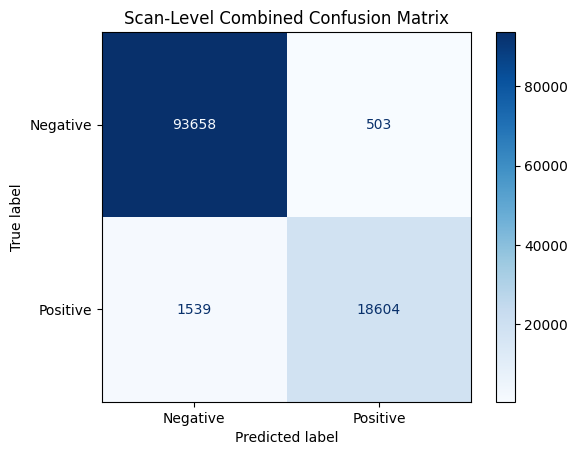

                           Biomarker       AUC  Precision    Recall        F1
0                            Atrophy  0.994803   0.976190  0.594203  0.738739
1                   Disruption of EZ  0.990680   0.928767  0.656977  0.769580
2                               DRIL  0.998144   1.000000  0.724138  0.840000
3                     IR hemorrhages  0.987277   0.962963  0.657040  0.781116
4                             IR HRF  0.971151   0.961054  0.892743  0.925640
5   Partially attached vitreous face  0.998967   0.990463  0.975117  0.982730
6       Fully attached vitreous face  0.999516   0.997013  0.984759  0.990848
7       Preretinal tissue/hemorrhage  0.999520   0.989181  0.945347  0.966767
8                    Vitreous debris  0.983433   0.928177  0.879163  0.903005
9                                VMT  1.000000   0.000000  0.000000  0.000000
10                            DRT/ME  0.999404   0.988506  0.978556  0.983506
11                       Fluid (IRF)  0.993391   0.970236  0.936

<Figure size 600x400 with 0 Axes>

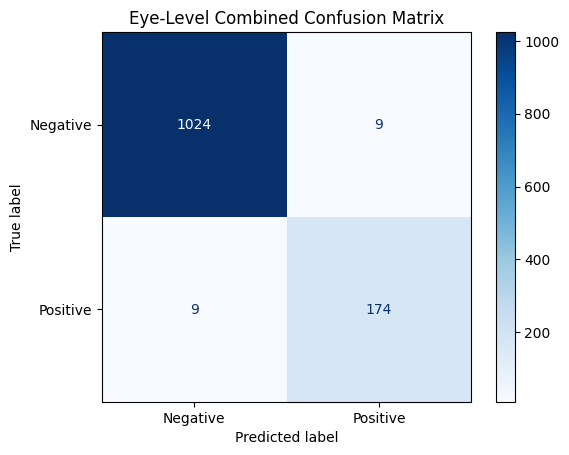

                           Biomarker       AUC  Precision    Recall        F1
0                            Atrophy       NaN   0.000000  0.000000  0.000000
1                   Disruption of EZ  1.000000   0.000000  0.000000  0.000000
2                               DRIL       NaN   0.000000  0.000000  0.000000
3                     IR hemorrhages  1.000000   1.000000  1.000000  1.000000
4                             IR HRF  1.000000   1.000000  0.947368  0.972973
5   Partially attached vitreous face  1.000000   0.904762  1.000000  0.950000
6       Fully attached vitreous face  1.000000   1.000000  1.000000  1.000000
7       Preretinal tissue/hemorrhage  1.000000   1.000000  0.750000  0.857143
8                    Vitreous debris  0.997696   0.777778  1.000000  0.875000
9                                VMT       NaN   0.000000  0.000000  0.000000
10                            DRT/ME  1.000000   1.000000  0.823529  0.903226
11                       Fluid (IRF)  0.987681   0.906250  0.966

<Figure size 600x400 with 0 Axes>

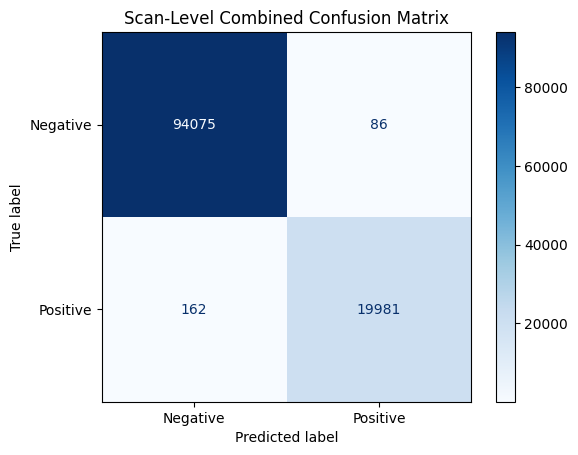

                           Biomarker       AUC  Precision    Recall        F1
0                            Atrophy  1.000000   1.000000  1.000000  1.000000
1                   Disruption of EZ  0.999681   0.991984  0.959302  0.975369
2                               DRIL  0.999990   0.965517  0.965517  0.965517
3                     IR hemorrhages  0.999913   0.985348  0.971119  0.978182
4                             IR HRF  0.998627   0.991071  0.992126  0.991598
5   Partially attached vitreous face  0.999992   0.998122  0.998122  0.998122
6       Fully attached vitreous face  0.999999   0.999508  0.999508  0.999508
7       Preretinal tissue/hemorrhage  0.999994   0.998512  0.991137  0.994811
8                    Vitreous debris  0.999120   0.992740  0.975737  0.984165
9                                VMT  1.000000   1.000000  1.000000  1.000000
10                            DRT/ME  0.999991   0.999121  0.995186  0.997150
11                       Fluid (IRF)  0.999758   0.996693  0.995

<Figure size 600x400 with 0 Axes>

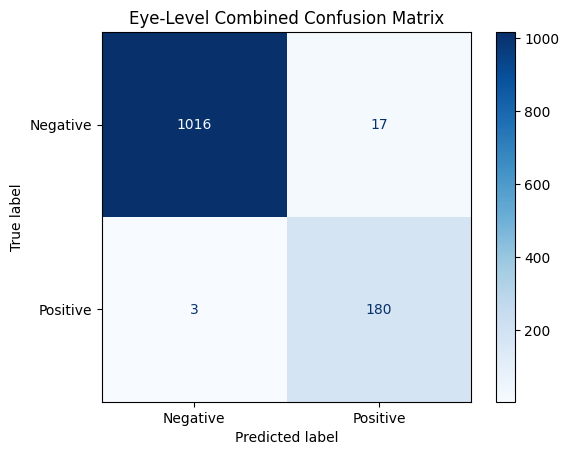

                           Biomarker       AUC  Precision    Recall        F1
0                            Atrophy       NaN   0.000000  0.000000  0.000000
1                   Disruption of EZ  1.000000   1.000000  1.000000  1.000000
2                               DRIL       NaN   0.000000  0.000000  0.000000
3                     IR hemorrhages  1.000000   1.000000  1.000000  1.000000
4                             IR HRF  1.000000   0.966102  1.000000  0.982759
5   Partially attached vitreous face  1.000000   0.950000  1.000000  0.974359
6       Fully attached vitreous face  1.000000   0.952381  1.000000  0.975610
7       Preretinal tissue/hemorrhage  0.996528   0.800000  1.000000  0.888889
8                    Vitreous debris  0.994240   1.000000  0.785714  0.880000
9                                VMT       NaN   0.000000  0.000000  0.000000
10                            DRT/ME  0.998006   0.850000  1.000000  0.918919
11                       Fluid (IRF)  0.989855   0.789474  1.000

In [5]:
# Evaluate models
print("Evaluating ImageModel without Clinical Data...")
scan_metrics_no_clinical, eye_metrics_no_clinical = evaluate_with_eye_aggregation(
    ImageModel, testloader
)
print("Evaluating FusionModel with Clinical Data...")
scan_metrics_clinical, eye_metrics_clinical = evaluate_with_eye_aggregation(
    FusionModel, testloader
)


Even more Plots


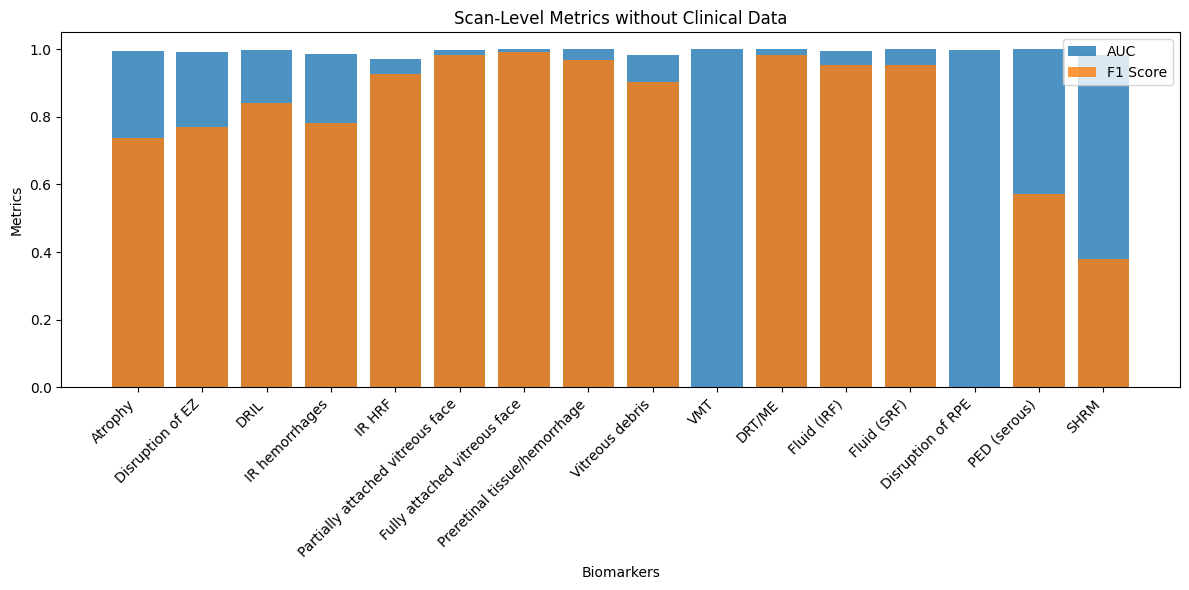

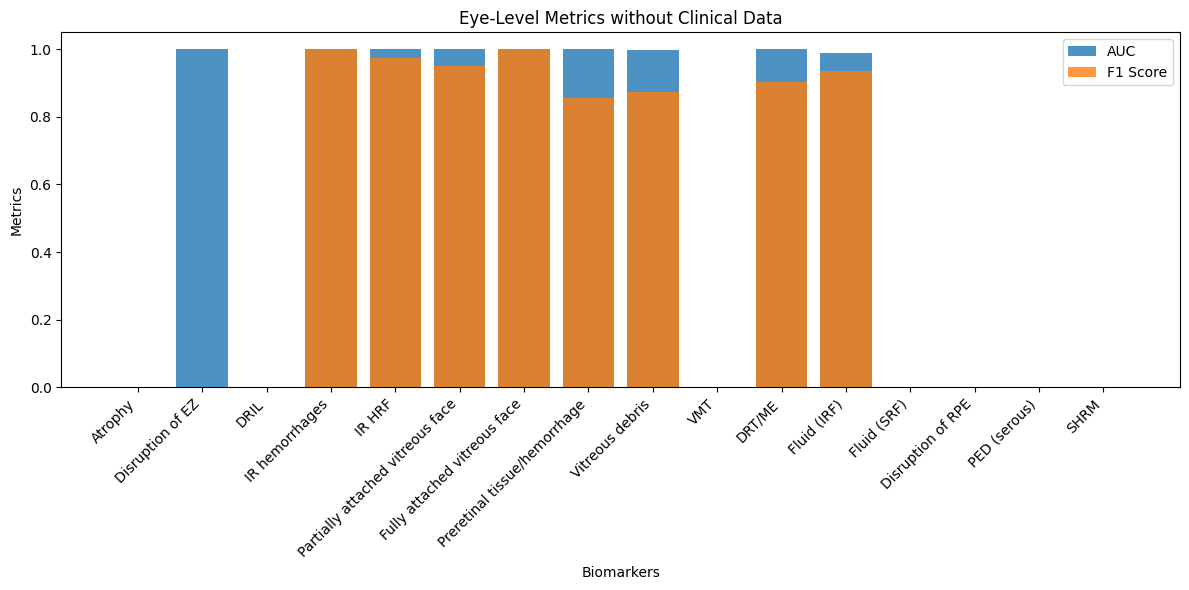

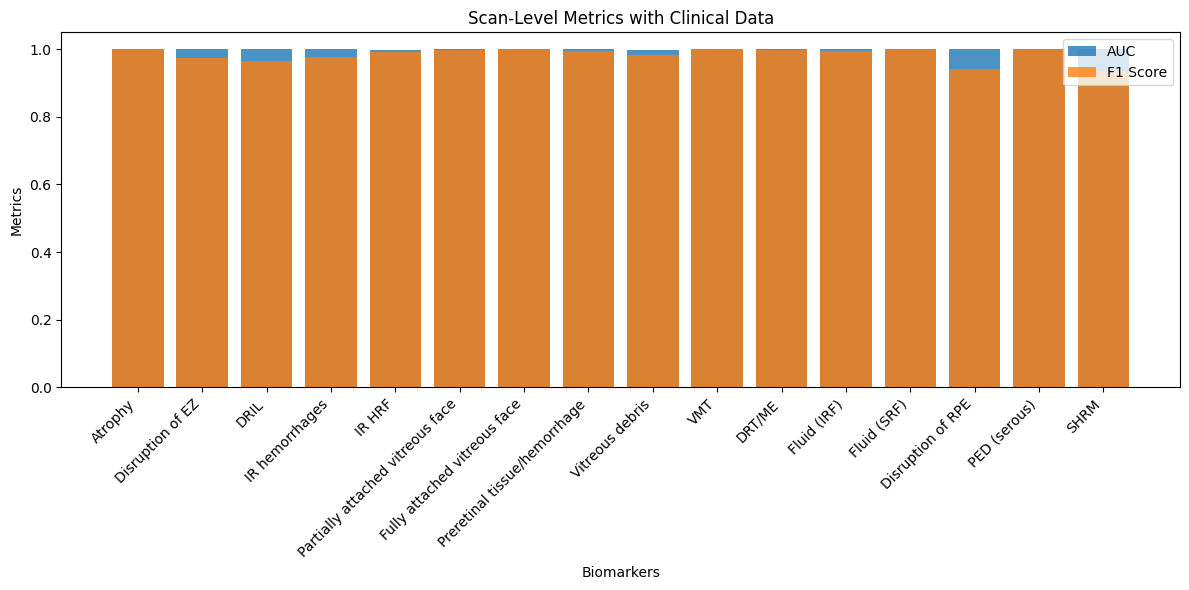

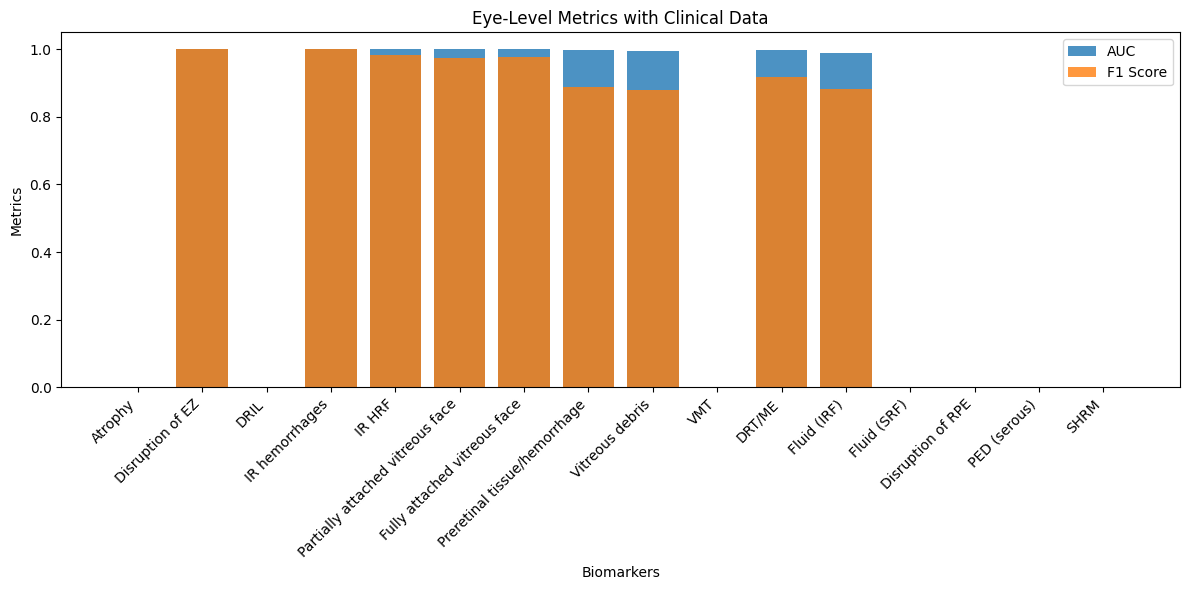


Ablation Study Results:
Clinical Data Impact on Biomarker Detection
                           Biomarker  F1 with Clinical Data  \
0                            Atrophy               1.000000   
1                   Disruption of EZ               0.975369   
2                               DRIL               0.965517   
3                     IR hemorrhages               0.978182   
4                             IR HRF               0.991598   
5   Partially attached vitreous face               0.998122   
6       Fully attached vitreous face               0.999508   
7       Preretinal tissue/hemorrhage               0.994811   
8                    Vitreous debris               0.984165   
9                                VMT               1.000000   
10                            DRT/ME               0.997150   
11                       Fluid (IRF)               0.996034   
12                       Fluid (SRF)               1.000000   
13                 Disruption of RPE             

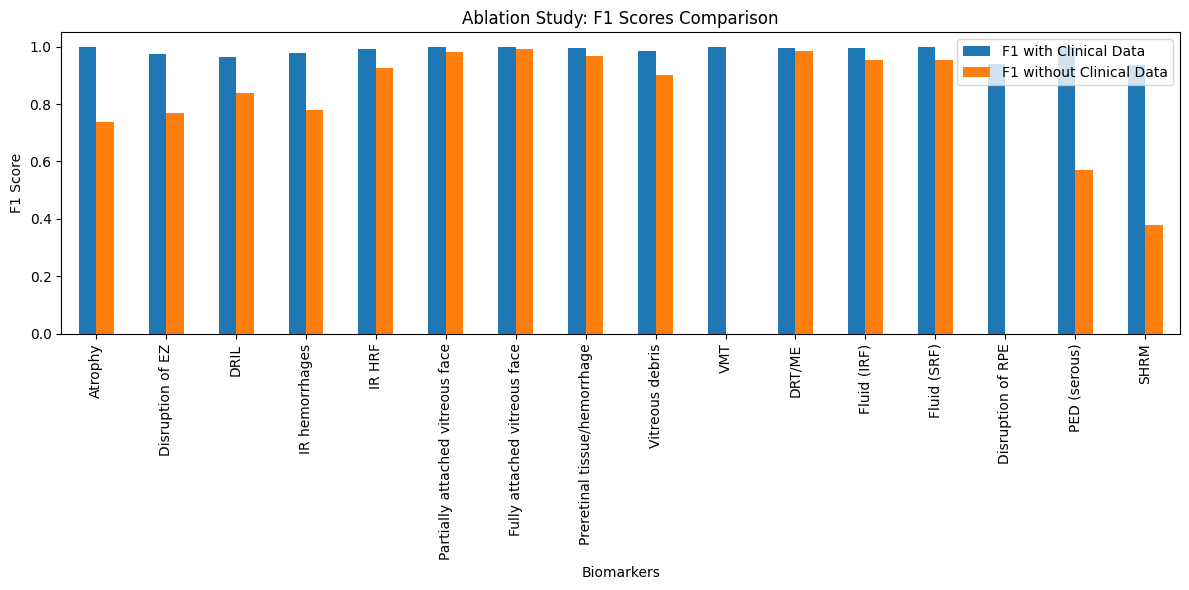

In [6]:
# Biomarker Labels
labels = [
    "Atrophy", "Disruption of EZ", "DRIL", "IR hemorrhages", "IR HRF",
    "Partially attached vitreous face", "Fully attached vitreous face",
    "Preretinal tissue/hemorrhage", "Vitreous debris", "VMT","DRT/ME", "Fluid (IRF)","Fluid (SRF)", "Disruption of RPE",
     "PED (serous)", "SHRM"
]

# Plot results
plot_metrics(scan_metrics_no_clinical, "Scan-Level Metrics without Clinical Data")
if eye_metrics_no_clinical is not None:
    plot_metrics(eye_metrics_no_clinical, "Eye-Level Metrics without Clinical Data")
    
plot_metrics(scan_metrics_clinical, "Scan-Level Metrics with Clinical Data")
if eye_metrics_clinical is not None:
    plot_metrics(eye_metrics_clinical, "Eye-Level Metrics with Clinical Data")

# Ablation Study
print("\nAblation Study Results:")
print("Clinical Data Impact on Biomarker Detection")
comparison = pd.DataFrame({
    "Biomarker": labels,
    "F1 with Clinical Data": scan_metrics_clinical["F1"],
    "F1 without Clinical Data": scan_metrics_no_clinical["F1"],
})
print(comparison)
comparison.plot(x="Biomarker", kind="bar", figsize=(12, 6), title="Ablation Study: F1 Scores Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

### Step 4: Result Grad-CAM Visualization

Hoooks and Grad-CAM class

In [38]:
import random
import torch.nn.functional as F
from matplotlib.patches import Rectangle

# Define the Grad-CAM class
class GradCAM:
    def __init__(self, model_object, target_layer):
        """
        Args:
            model_object: Pretrained model (e.g., ResNet50).
            target_layer: The specific layer to hook (e.g., 'layer4[2].conv2').
        """
        self.model = model_object
        self.gradients = dict()
        self.activations = dict()

        # Register hooks
        def backward_hook(module, grad_input, grad_output):
            self.gradients["value"] = grad_output[0]
            return None

        def forward_hook(module, input, output):
            self.activations["value"] = output
            return None

        target_layer.register_backward_hook(backward_hook)
        target_layer.register_forward_hook(forward_hook)

    def calculate(self, input_tensor, class_idx, clinical_data=None):
        """
        Args:
            input_tensor: Input image (1, 3, H, W).
            class_idx: Index of the biomarker to compute Grad-CAM for.

        Returns:
            saliency_map: Grad-CAM saliency map (H, W).
        """
        self.model.eval()

        # Forward pass
        input_tensor = input_tensor.to(device)  # Ensure input is on the same device as the model
        if clinical_data is None:
            logit = self.model(input_tensor)
        else:
            logit = self.model(input_tensor,clinical_data)
            
        target_logit = logit[:, class_idx]
        
        # Backward pass
        self.model.zero_grad()
        target_logit.backward(retain_graph=True)

        # Grad-CAM computation
        gradients = self.gradients["value"]
        activations = self.activations["value"]
        b, k, u, v = gradients.size()

        alpha = torch.mean(gradients, dim=(2, 3))  # Global average pooling
        alpha = alpha.view(b, k, 1, 1)
        saliency_map = F.relu(torch.sum(alpha * activations, dim=1))

        # Normalize the saliency map
        saliency_map = F.interpolate(
            saliency_map.unsqueeze(1), size=(input_tensor.size(2), input_tensor.size(3)),
            mode="bilinear", align_corners=False
        ).squeeze()
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min + 1e-8)
        
        # get prediction
        prediction = (torch.sigmoid(target_logit) > 0.5).int().cpu().numpy()
        
        return saliency_map, prediction

Random index: 1387


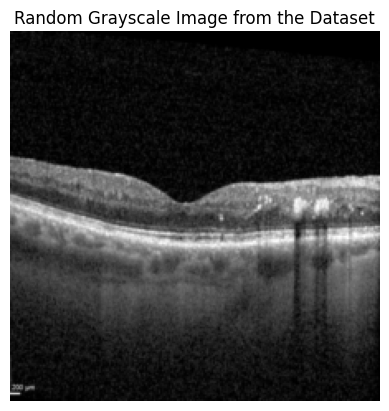

Grad-CAM for ResNet


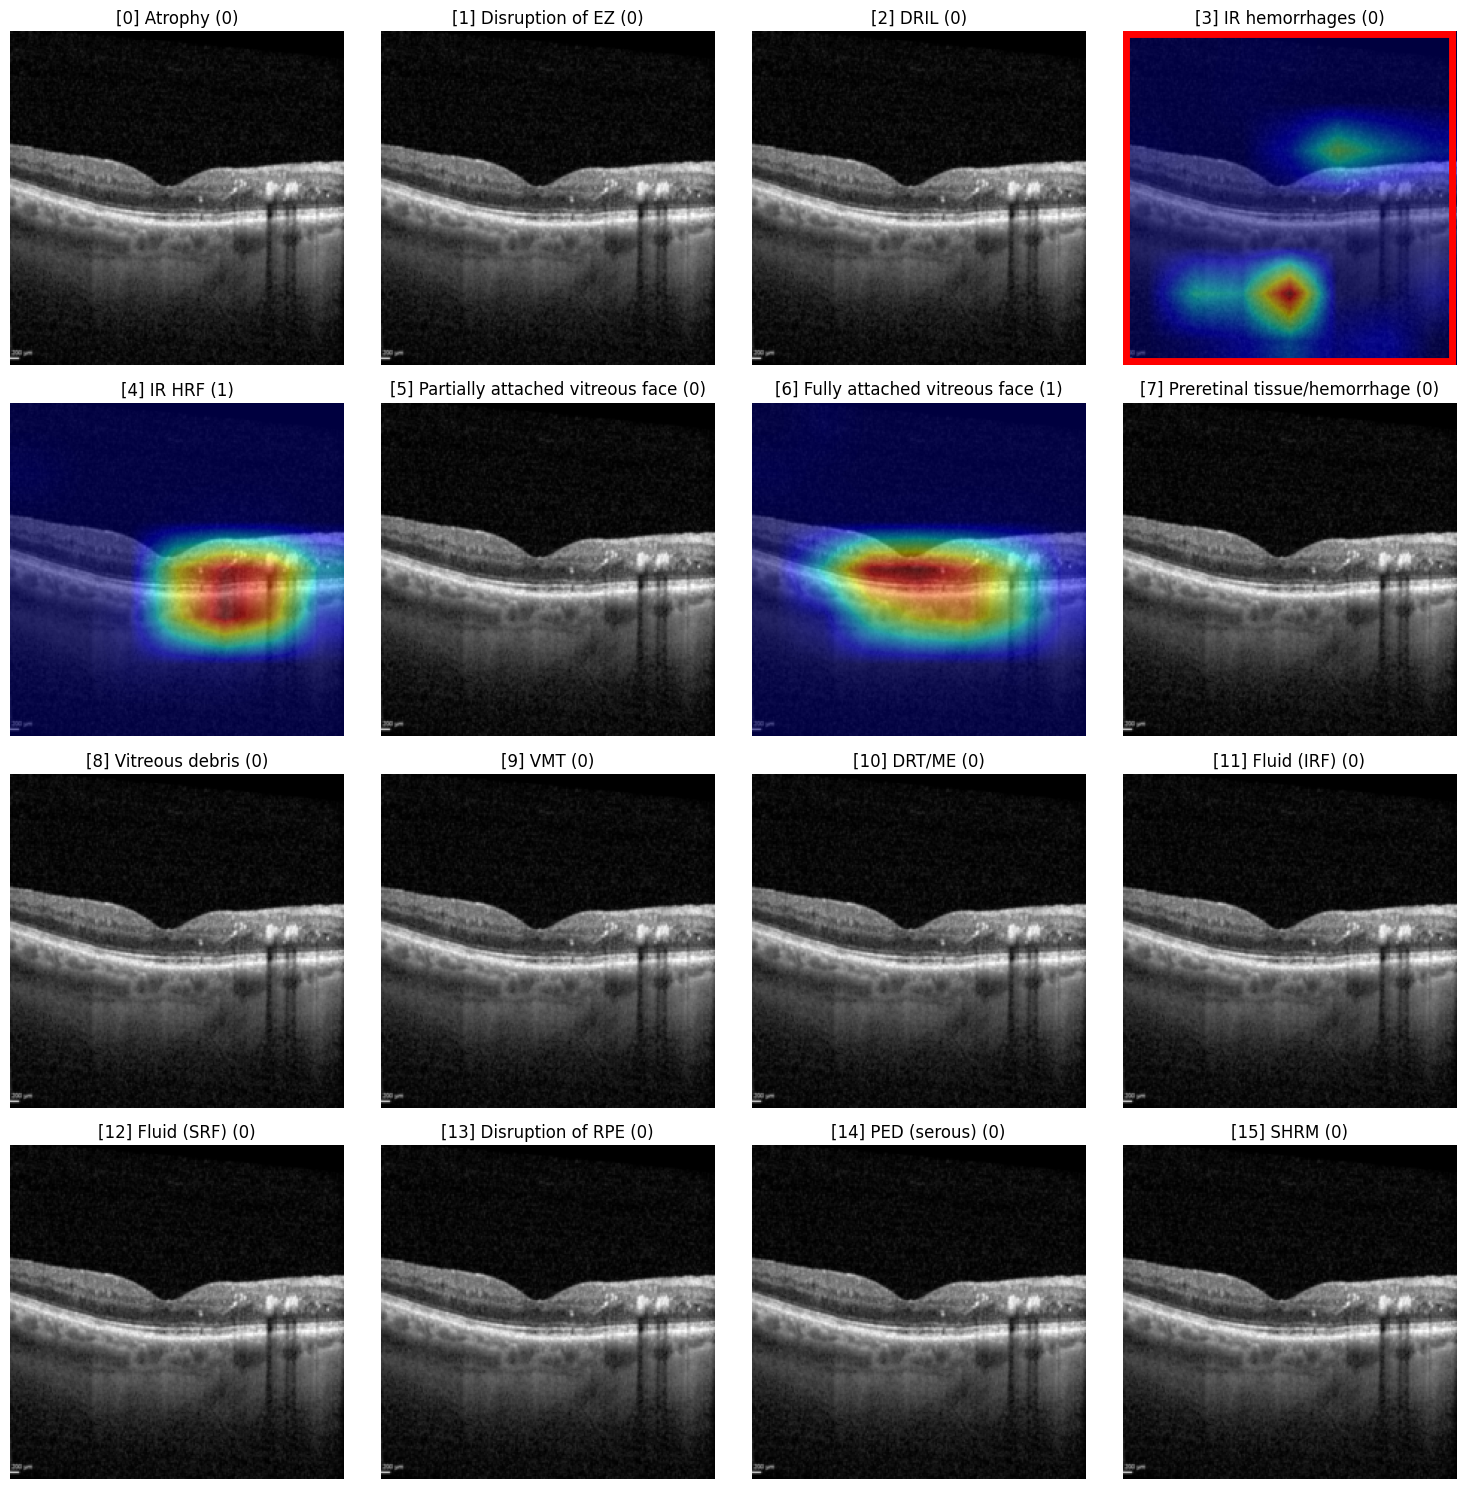

Grad-CAM for FusionModel


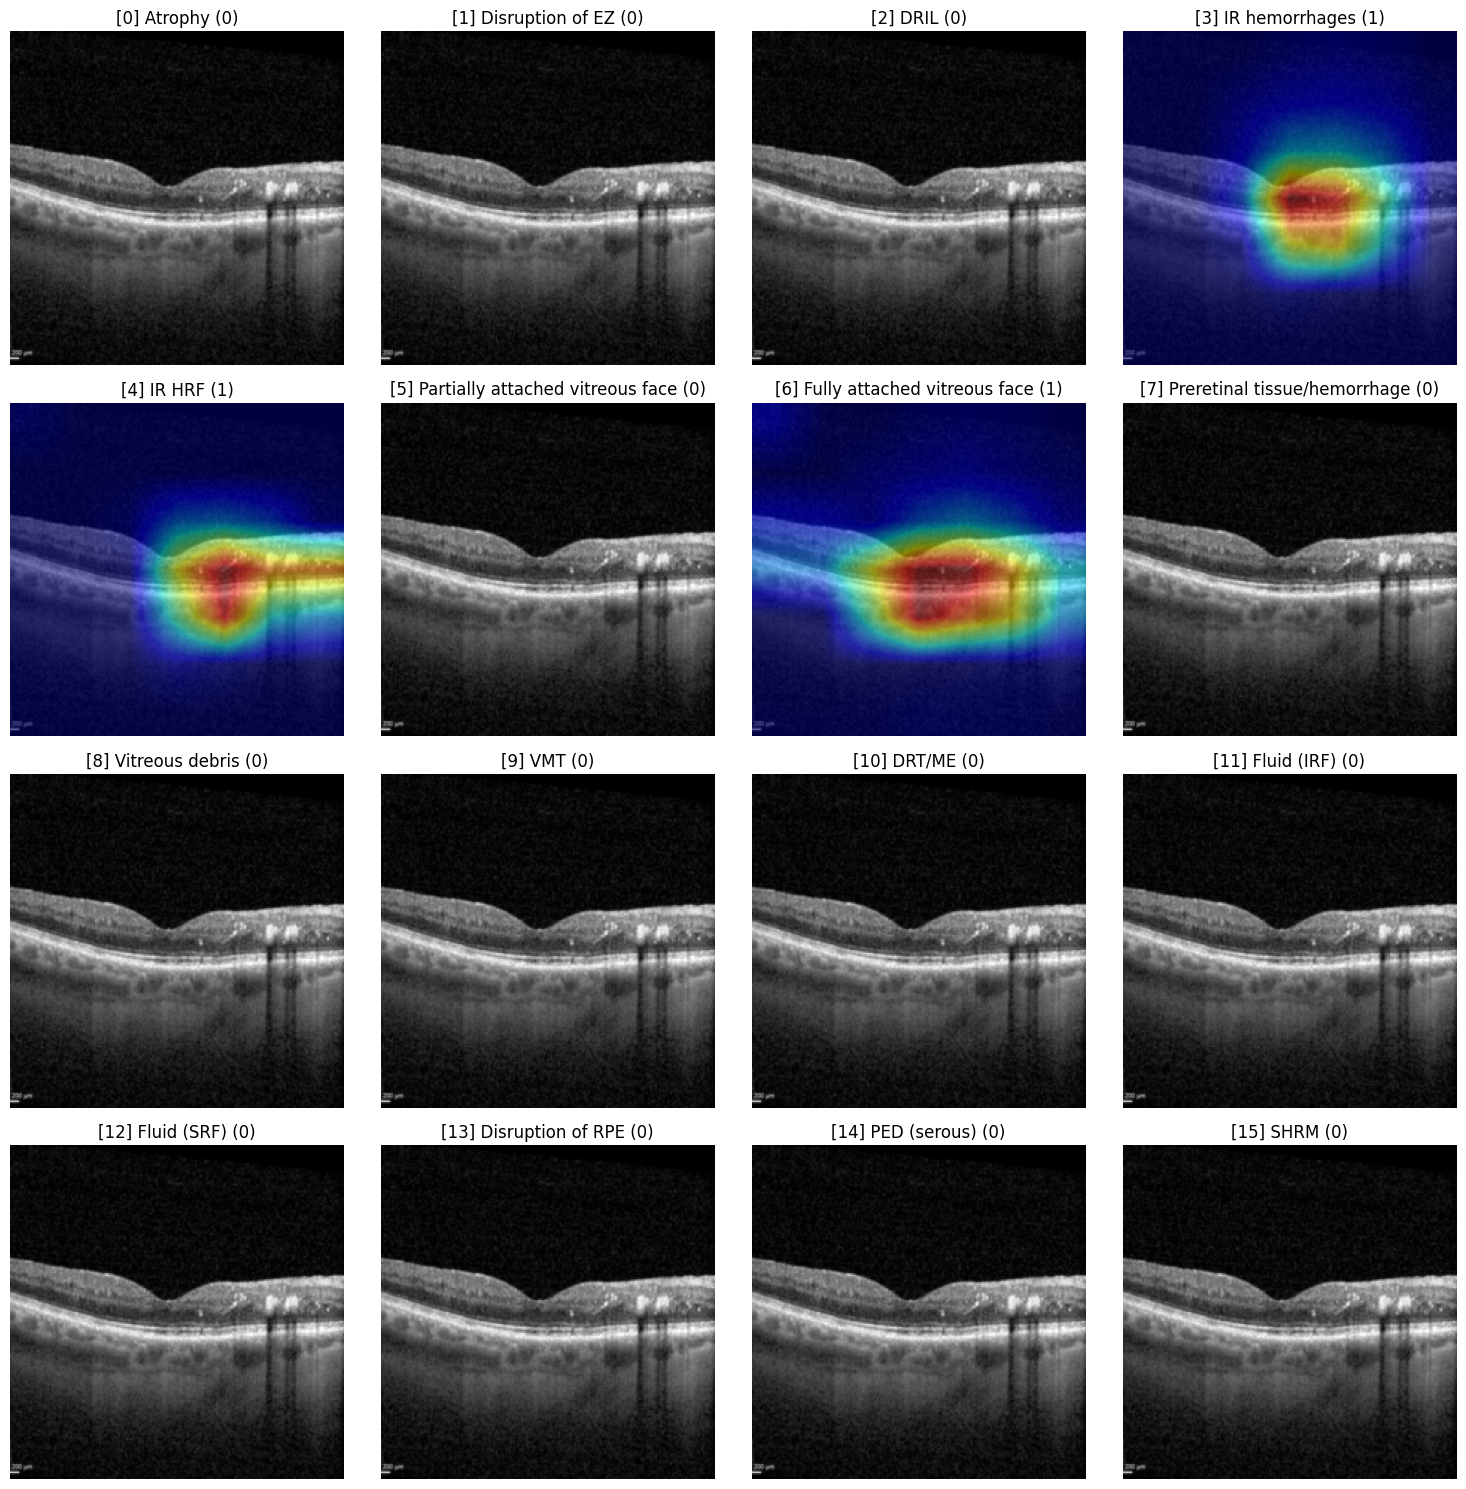

In [52]:

# Define the labels for the biomarkers
BiomarkerLables = [
    "Atrophy", "Disruption of EZ", "DRIL", "IR hemorrhages", "IR HRF",
    "Partially attached vitreous face", "Fully attached vitreous face",
    "Preretinal tissue/hemorrhage", "Vitreous debris", "VMT", "DRT/ME", "Fluid (IRF)",
    "Fluid (SRF)", "Disruption of RPE", "PED (serous)", "SHRM"
]


# Pick a random index from the dataset
random_index = random.randint(0, len(test_dataset) - 1)
# optional overwrite the index
# random_index = 2193
# random_index = 1387
print(f"Random index: {random_index}")

# Fetch the sample
images, labels, clinical_data = test_dataset[random_index]

# Undo normalization for visualization of grayscale channel
grayscale_image = images[1].cpu().numpy() * std + mean  # Grayscale for visualization

# Plot the grayscale image
plt.imshow(grayscale_image, cmap='gray')
plt.title("Random Grayscale Image from the Dataset")
plt.axis('off')
plt.show()

# Prepare the image (3-channel) for input to the model
input_image = images.unsqueeze(0).to(device)  # Add batch dimension, move to device
clinical_data = clinical_data.unsqueeze(0).to(device)

# Define the models and target layers
# ([Model], [Target Layer], [Show grad-CAM for all biomarkers (0 is only for detected)])
GradCamVisInput = [
    (ImageModel, ImageModel.layer4, 0),  # ImageModel.layer4[2].conv2
    (FusionModel, FusionModel.image_model.layer4, 0)
]

# Loop through each model
for model, target_layer, show_all_gradCAM in GradCamVisInput:
    # Initialize Grad-CAM
    gradcam = GradCAM(model, target_layer)
    
    # Grad-CAM for biomarkers
    gradcam_maps = []
    pred_map = []
    for biomarker_idx in range(16):
        saliency_map, pred_singleBiomarker = gradcam.calculate(input_image, biomarker_idx, clinical_data=clinical_data if model == FusionModel else None)
        gradcam_maps.append(saliency_map.cpu().detach().numpy())
        pred_map.append(pred_singleBiomarker)
    
    # Print which model is being processed
    print(f"Grad-CAM for {model.__class__.__name__}")
    
    # Plot the Grad-CAM maps for all biomarkers
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        # If the Grad-CAM map is not zero (meaning the biomarker was detected)
        if labels[i] > 0.5 or show_all_gradCAM > 0:
            heatmap = gradcam_maps[i]
            ax.imshow(grayscale_image, cmap="gray")
            ax.imshow(heatmap, cmap="jet", alpha=0.5)  # Overlay heatmap
        else:
            # If no biomarker is detected, just show the grayscale image
            ax.imshow(grayscale_image, cmap="gray")
        
        # Set the title with the biomarker name and index
        ax.set_title(f"[{i}] {BiomarkerLables[i]} ({int(pred_map[i])})")
        ax.axis("off")
        
        # Add a red box if prediction is wrong
        if labels[i] != int(pred_map[i]):
            # Add a red rectangle around the axes
            rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, color='red', linewidth=10, fill=False)
            ax.add_patch(rect)
    
    plt.tight_layout()
    plt.show()

    
